<a href="https://colab.research.google.com/github/SauloHenriqueAguiar/agrismartsystem/blob/main/DeepLearning/TreinoMultivarLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing bibliotecas
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saulohenriaguiar","key":"f39a97212cfdbde2b816fdffcb292e24"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download -d mohitsingh1804/crop-recommendation

  0% 0.00/63.7k [00:00<?, ?B/s]
100% 63.7k/63.7k [00:00<00:00, 53.7MB/s]


In [8]:
! unzip crop-recommendation.zip

Archive:  crop-recommendation.zip
  inflating: Crop_recommendation.csv  


In [9]:
df = pd.read_csv("Crop_recommendation.csv", delimiter=",")

In [10]:
df

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee


In [11]:
df['time'] = pd.date_range('11/5/2015', periods = 2200, freq ='1D')

In [12]:
df

,N,P,K,temperature,humidity,ph,rainfall,label,time
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,2015-11-05
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,2015-11-06
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,2015-11-07
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,2015-11-08
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,2015-11-09
...,...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee,2021-11-08
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee,2021-11-09
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee,2021-11-10
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee,2021-11-11


In [13]:
## features 

features_3 = ['temperature', 'humidity', 'ph']

features = df[features_3]
features.index = df['time']
features.head()

,temperature,humidity,ph
time,,,
2015-11-05,20.879744,82.002744,6.502985
2015-11-06,21.770462,80.319644,7.038096
2015-11-07,23.004459,82.320763,7.840207
2015-11-08,26.491096,80.158363,6.980401
2015-11-09,20.130175,81.604873,7.628473


In [14]:
dataset = features
dataset

,temperature,humidity,ph
time,,,
2015-11-05,20.879744,82.002744,6.502985
2015-11-06,21.770462,80.319644,7.038096
2015-11-07,23.004459,82.320763,7.840207
2015-11-08,26.491096,80.158363,6.980401
2015-11-09,20.130175,81.604873,7.628473
...,...,...,...
2021-11-08,26.774637,66.413269,6.780064
2021-11-09,27.417112,56.636362,6.086922
2021-11-10,24.131797,67.225123,6.362608


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f99d371cad0>,
      dtype=object)

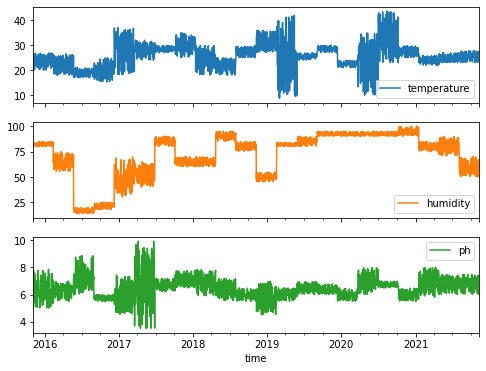

In [15]:
dataset.plot(subplots=True)

In [16]:
## divisão de teste  para média de janela móvel de série temporal simples
train_split = 1200
tf.random.set_seed(13)

In [17]:
### standardize data
dataset = features.values

data_mean = dataset[:train_split].mean(axis =0)

data_std = dataset[:train_split].std(axis = 0)

dataset = (dataset - data_mean)/data_std

In [18]:
### criar mutlivariate dataset

def mutlivariate_data(dataset , target , start_idx , end_idx , history_size , target_size,
                      step ,  single_step = False):
  data = []
  labels = []
  start_idx = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx ):
    idxs = range(i-history_size, i, step) ### using step
    data.append(dataset[idxs])
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data) , np.array(labels)

In [19]:
### função para criar passos de tempo
def create_time_steps(length):
  return list(range(-length,0))

### função para plotar dados de séries temporais

def plot_time_series(plot_data, delta , title):
  labels = ["Histórico" , 'Valor Futuro Verdadeiro' , 'Valor Predito Pelo Modelo']
  marker = ['.-' , 'rx' , 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i , x in enumerate(plot_data):
    if i :
      plt.plot(future , plot_data[i] , marker[i], markersize = 10 , label = labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5) *2])

  plt.xlabel('Time_Step')
  return plt

In [20]:
### generate multivariate data

history = 720
future_target = 72
STEP = 6

x_train_ss , y_train_ss = mutlivariate_data(dataset , dataset[:, 1], 0, train_split, history,
                                            future_target, STEP , single_step = True)

x_val_ss , y_val_ss = mutlivariate_data(dataset , dataset[:,1] , train_split , None , history ,
                                        future_target, STEP, single_step = True)

print(x_train_ss.shape , y_train_ss.shape)

(480, 120, 3) (480,)


In [21]:
## tensorflow dataset
batch_size = 256
buffer_size = 10000
train_ss = tf.data.Dataset.from_tensor_slices((x_train_ss, y_train_ss))
train_ss = train_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_ss = tf.data.Dataset.from_tensor_slices((x_val_ss, y_val_ss))
val_ss = val_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_ss)
print(val_ss)

<RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [108]:
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers


layer = layers.Dense(
    units=32,
    kernel_regularizer=regularizers.L1L2(l1=1e-1, l2=1e-1),
    bias_regularizer=regularizers.L2(1e-4),
    activity_regularizer=regularizers.L2(1e-5)
)

In [117]:
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers


layer = layers.Dense(
    units=16,
    kernel_regularizer=regularizers.L1L2(l1=1e-1, l2=1e-1),
    bias_regularizer=regularizers.L2(1e-4),
    activity_regularizer=regularizers.L2(1e-5)
)


In [118]:
## treinamento da modelo LSTM
steps = 200
EPOCHS =20
single_step_model = tf.keras.models.Sequential()

single_step_model.add(tf.keras.layers.LSTM(32, input_shape = x_train_ss.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
single_step_model.add(layer)
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mae')
modelo = single_step_model.fit(train_ss, epochs = EPOCHS , 
                                                  steps_per_epoch =steps, validation_data = val_ss,
                                                  validation_steps = 50)

Epoch 1/20
200/200 [==============================] - 4s 11ms/step - loss: 5.0215 - val_loss: 3.0182
Epoch 2/20
200/200 [==============================] - 2s 8ms/step - loss: 1.3787 - val_loss: 0.8077
Epoch 3/20
200/200 [==============================] - 2s 8ms/step - loss: 0.4030 - val_loss: 0.5836
Epoch 4/20
200/200 [==============================] - 2s 8ms/step - loss: 0.2934 - val_loss: 0.7310
Epoch 5/20
200/200 [==============================] - 2s 9ms/step - loss: 0.2627 - val_loss: 0.7286
Epoch 6/20
200/200 [==============================] - 2s 8ms/step - loss: 0.2387 - val_loss: 0.6718
Epoch 7/20
200/200 [==============================] - 2s 8ms/step - loss: 0.2208 - val_loss: 0.5536
Epoch 8/20
200/200 [==============================] - 2s 9ms/step - loss: 0.2070 - val_loss: 0.4864
Epoch 9/20
200/200 [==============================] - 2s 9ms/step - loss: 0.1961 - val_loss: 0.4502
Epoch 10/20
200/200 [==============================] - 2s 8ms/step - loss: 0.1876 - val_loss: 0.502

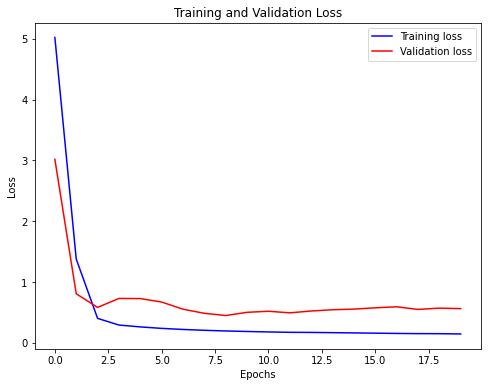

Final val loss:  [3.0181891918182373, 0.807715892791748, 0.5835822224617004, 0.7309858798980713, 0.7285602688789368, 0.671775758266449, 0.5536404848098755, 0.48639798164367676, 0.4502107501029968, 0.5026314854621887, 0.5204622745513916, 0.4937901794910431, 0.5243585705757141, 0.544797420501709, 0.5553049445152283, 0.576771080493927, 0.5935725569725037, 0.5500913858413696, 0.5716887712478638, 0.5631071925163269]


In [119]:
def visualize_loss(history, title):
    loss = modelo.history["loss"]
    val_loss = modelo.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    print("Final val loss: ", val_loss)

visualize_loss(history, "Training and Validation Loss")

In [121]:
#sumário do modelo multiparametros
single_step_model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 32)                4608      
                                                                 
 dense_112 (Dense)           (None, 16)                528       
                                                                 
 dense_111 (Dense)           (None, 16)                272       
                                                                 
 dense_113 (Dense)           (None, 1)                 17        
                                                                 
Total params: 5,425
Trainable params: 5,425
Non-trainable params: 0
_________________________________________________________________


7/7 [==============================] - 0s 4ms/step


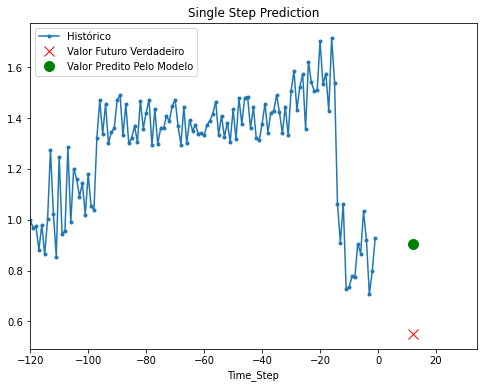

7/7 [==============================] - 0s 5ms/step


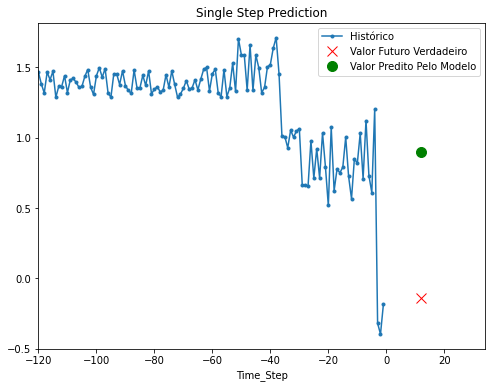

7/7 [==============================] - 0s 5ms/step


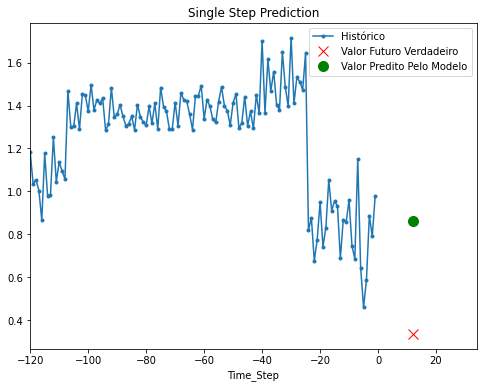

7/7 [==============================] - 0s 4ms/step


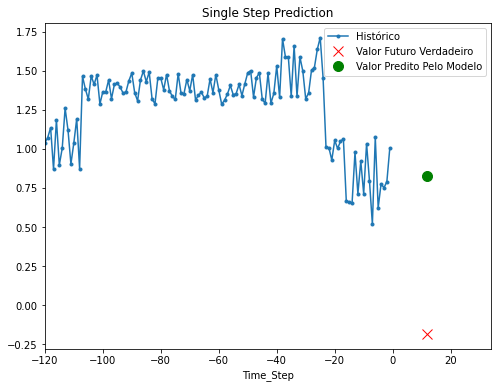

7/7 [==============================] - 0s 4ms/step


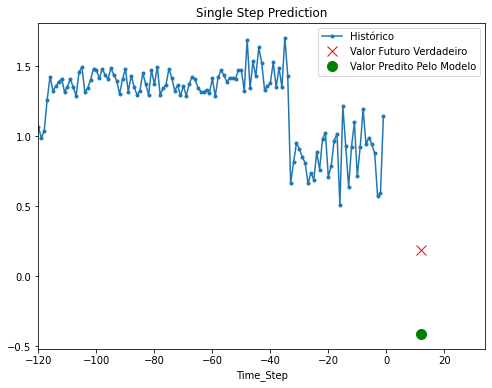

In [122]:
# plotar séries temporais e valores previstos

for x, y in val_ss.take(5):
  plot = plot_time_series([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [123]:
future_target = 72 # 72 future values
x_train_multi, y_train_multi = mutlivariate_data(dataset, dataset[:, 1], 0,
                                                 train_split, history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = mutlivariate_data(dataset, dataset[:, 1],
                                             train_split, None, history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)

(480, 120, 3)
(480, 72)


In [124]:
# TF DATASET

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()

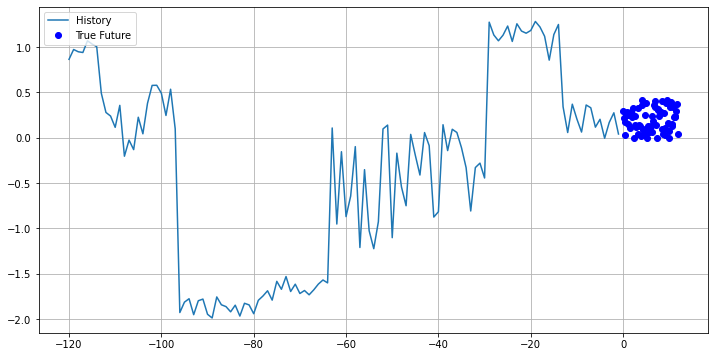

In [125]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  


for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [130]:
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers


layer = layers.Dense(
    units=16,
    kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),
    bias_regularizer=regularizers.L2(1e-4),
    activity_regularizer=regularizers.L2(1e-5)
)

In [131]:
EPOCHS = 5
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(layer)
multi_step_model.add(tf.keras.layers.Dense(72)) # for 72 outputs

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=steps,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/5
200/200 [==============================] - 47s 222ms/step - loss: 0.3223 - val_loss: 0.4801
Epoch 2/5
200/200 [==============================] - 44s 219ms/step - loss: 0.2031 - val_loss: 0.6220
Epoch 3/5
200/200 [==============================] - 43s 218ms/step - loss: 0.1838 - val_loss: 0.6971
Epoch 4/5
200/200 [==============================] - 43s 216ms/step - loss: 0.1683 - val_loss: 0.7247
Epoch 5/5
200/200 [==============================] - 43s 213ms/step - loss: 0.1588 - val_loss: 0.6815


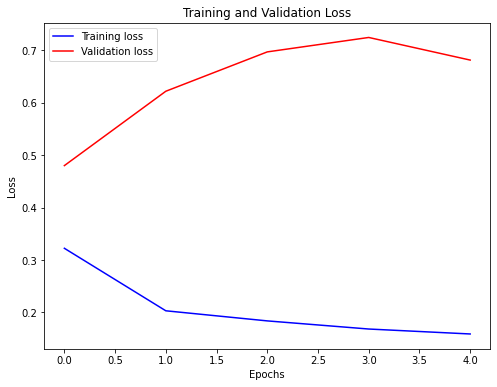

Final val loss:  [0.480121374130249, 0.6220374703407288, 0.6971178650856018, 0.7246517539024353, 0.6815051436424255]


In [133]:
def visualize_loss(history, title):
    loss = multi_step_history.history["loss"]
    val_loss = multi_step_history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    print("Final val loss: ", val_loss)

visualize_loss(history, "Training and Validation Loss")

In [134]:
#sumário do modelo multiparametros
multi_step_model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_43 (LSTM)              (None, 120, 32)           4608      
                                                                 
 lstm_44 (LSTM)              (None, 16)                3136      
                                                                 
 dense_117 (Dense)           (None, 16)                272       
                                                                 
 dense_118 (Dense)           (None, 72)                1224      
                                                                 
Total params: 9,240
Trainable params: 9,240
Non-trainable params: 0
_________________________________________________________________


7/7 [==============================] - 1s 18ms/step


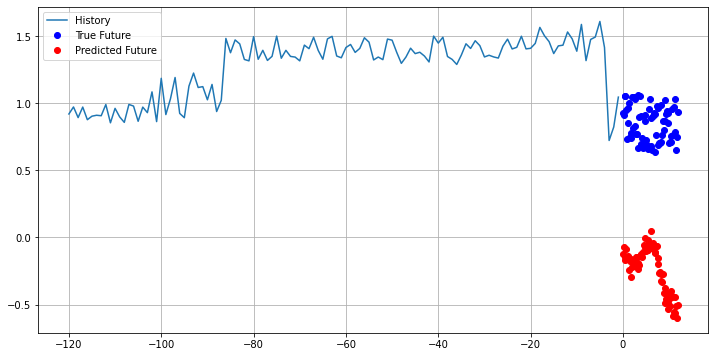

7/7 [==============================] - 0s 19ms/step


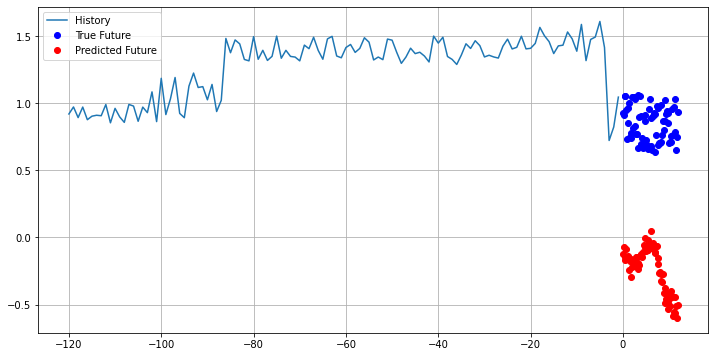

7/7 [==============================] - 0s 18ms/step


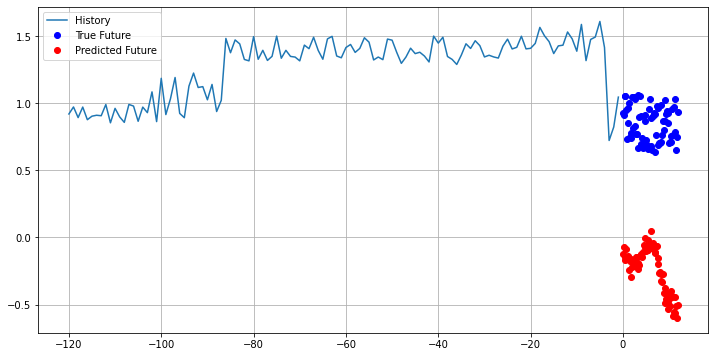

7/7 [==============================] - 0s 18ms/step


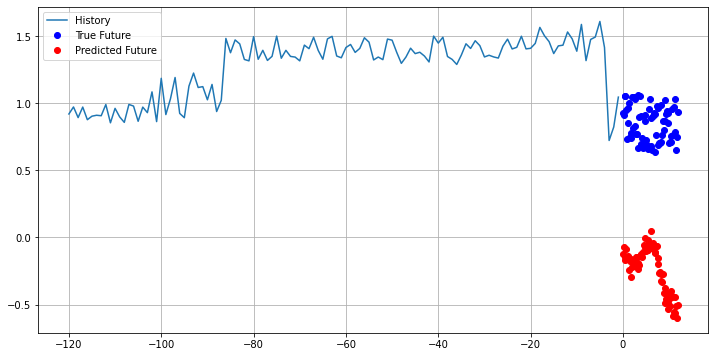

7/7 [==============================] - 0s 19ms/step


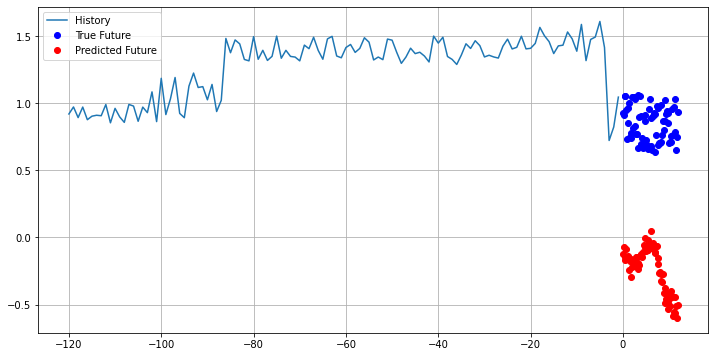

7/7 [==============================] - 0s 18ms/step


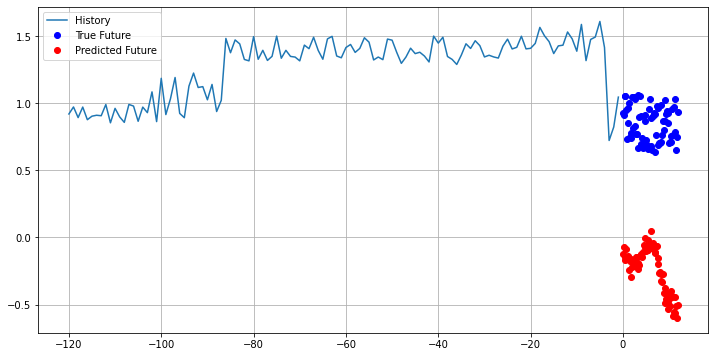

7/7 [==============================] - 0s 19ms/step


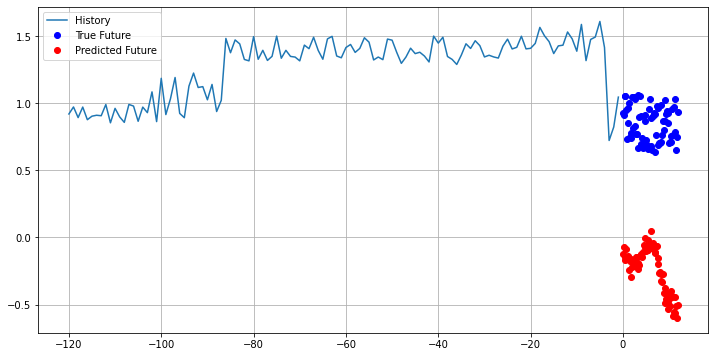

7/7 [==============================] - 0s 20ms/step


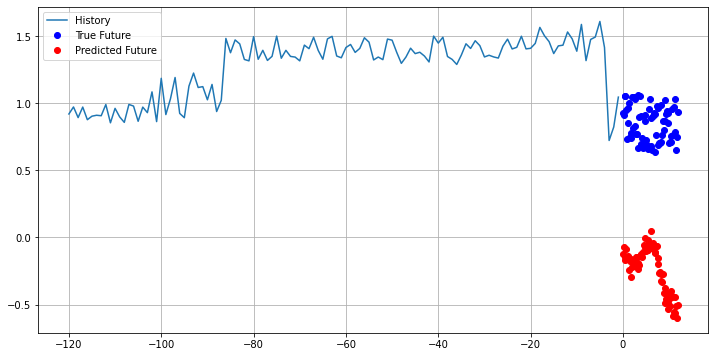

7/7 [==============================] - 0s 19ms/step


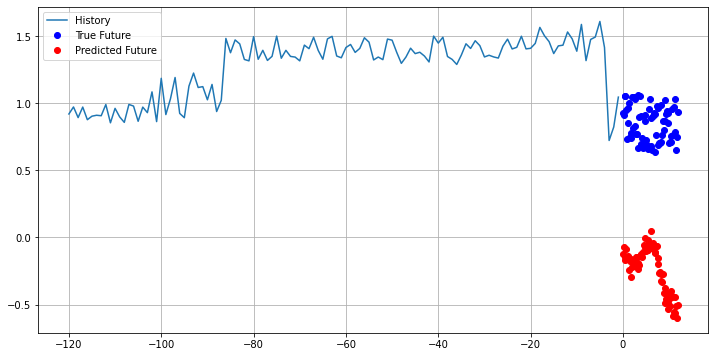

7/7 [==============================] - 0s 20ms/step


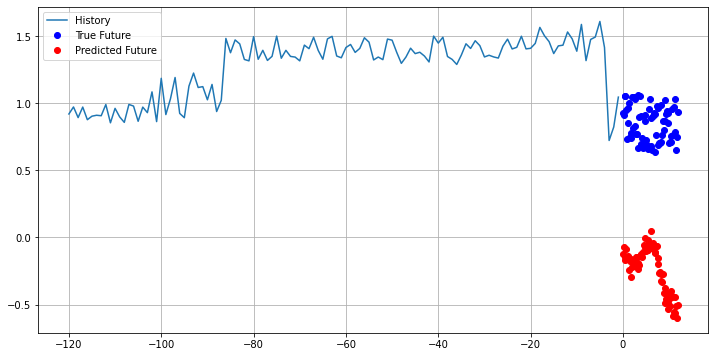

In [135]:
# previsão de algumas séries temporais
for x, y in val_data_multi.take(10):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])